<a href="https://colab.research.google.com/github/Shekhawat34/Real-TIme-Stock-Market-Prediction/blob/main/CNN_LSTM_and_XGBoost_model_for_stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PROJECT:- CNN-LSTM and XGBoost Model For Stock Prediction

In [ ]:
import numpy as np
import pandas as pd
from sklearn import metrics
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import matplotlib.pyplot as plt

# define Augmented Dickey-Fuller (ADF) testm , auto correlation and partial auto correlation

In [ ]:
def perform_adf_test(series):
    """
    Performs the Augmented Dickey-Fuller test for stationarity on a given time series.

    Parameters:
        series (pandas.Series or array-like): Time series data.

    Returns:
        None (Prints the ADF test results)
    """
    result = adfuller(series)
    adf_output = pd.DataFrame({'Metric': ['ADF Statistic', 'p-value', 'No. of Lags Used', 'No. of Observations Used'],
                                 'Value': [result[0], result[1], result[2], result[3]]})

    for key, value in result[4].items():
        # Use pd.concat instead of append
        adf_output = pd.concat([adf_output, pd.DataFrame({'Metric': [f'Critical Value ({key})'], 'Value': [value]})], ignore_index=True)

    print(adf_output.set_index('Metric'))


def plot_acf_pacf(time_series, acf_lags=20, pacf_lags=20):
    """Generates ACF and PACF plots for a given time series."""
    plt.figure(figsize=(12, 8))
    plt.subplot(211)
    sm.graphics.tsa.plot_acf(time_series, lags=acf_lags)
    plt.title('Autocorrelation (ACF)')

    plt.subplot(212)
    sm.graphics.tsa.plot_pacf(time_series, lags=pacf_lags)
    plt.title('Partial Autocorrelation (PACF)')

    plt.tight_layout()
    plt.show()


def select_order_based_on_bic(data_diff, max_ar=6, max_ma=4):
    """Selects the optimal (p, q) order for ARMA model using Bayesian Information Criterion (BIC)."""
    selected_order = sm.tsa.arma_order_select_ic(data_diff, max_ar=max_ar, max_ma=max_ma, ic='bic')['bic_min_order']
    print(f"Optimal p and q values based on BIC: {selected_order[0]}, {selected_order[1]}")


In [ ]:
def find_optimal_arima_order(training_set):
    """
    Finds the optimal (p, d, q) order for an ARIMA model based on Bayesian Information Criterion (BIC).
    """

    # Differencing the series to make it stationary
    differenced_data = training_set['close'].diff().dropna()

    max_p, max_q = 5, 5
    bic_values = []
    print(f'Searching optimal (p, q) in range 0 to {max_p}')

    # Iterating over AR and MA order values to calculate BIC
    for p in range(max_p + 1):
        bic_row = []
        for q in range(max_q + 1):

            try:
                # Fitting ARIMA model with current (p, d=1, q) order
                model = sm.tsa.ARIMA(training_set['close'], order=(p, 1, q))
                result = model.fit()
                bic_row.append(result.bic)
            except Exception:
                # Append None if model fails to fit
                bic_row.append(None)
        bic_values.append(bic_row)

    # Convert BIC values into DataFrame
    bic_matrix = pd.DataFrame(bic_values, index=range(max_p + 1), columns=range(max_q + 1))

    # Identify (p, q) with minimum BIC value
    optimal_p, optimal_q = bic_matrix.stack().astype(float).idxmin()
    print(f'Optimal (p, q) based on BIC: ({optimal_p}, {optimal_q})')


## Prepare data for training and testing

In [ ]:
def generate_sequences(data, sequence_length=20):
    """
    Transforms the dataset into sequences of a specified look-back period for supervised learning.

    Parameters:
        data (numpy array): The input dataset.
        sequence_length (int): The number of previous time steps to consider for each input sequence.

    Returns:
        tuple: Arrays containing input sequences (X) and target values (Y).
    """
    input_data, output_data = [], []

    for idx in range(len(data) - sequence_length):
        # Extract sequence of input data and the corresponding output value
        input_data.append(data[idx : idx + sequence_length, :])
        output_data.append(data[idx + sequence_length, :])

    X = np.array(input_data)
    Y = np.array(output_data)

    return X, Y


In [ ]:

def evaluation_metric(y_test,y_hat):


    MSE = metrics.mean_squared_error(y_test, y_hat)
    RMSE = MSE**0.5
    MAE = metrics.mean_absolute_error(y_test,y_hat)
    R2 = metrics.r2_score(y_test,y_hat)


    print('MSE: %.5f' % MSE)
    print('RMSE: %.5f' % RMSE)
    print('MAE: %.5f' % MAE)
    print('R2: %.5f' % R2)


def GetMAPE(y_hat, y_test):
    sum = np.mean(np.abs((y_hat - y_test) / y_test)) * 100
    return sum

In [ ]:
def GetMAPE_Order(y_hat,y_test):
    zero_index = np.where(y_test == 0)
    y_hat = np.delete(y_hat, zero_index[0])
    y_test = np.delete(y_test, zero_index[0])
    sum = np.mean(np.abs((y_hat - y_test) / y_test)) * 100
    return sum

## Normalize the data

In [ ]:
import numpy as np

def normalize_multivariate(data):
    """
    Normalizes each feature in a multivariate dataset to the range [0, 1].

    Parameters:
        data (numpy array): 2D array where each column is a feature to be normalized.

    Returns:
        tuple: The normalized data array and an array of min-max values for each feature.
    """
    data = np.array(data, dtype='float64')
    normalization_params = np.zeros((data.shape[1], 2), dtype='float64')  # Stores min and max for each feature

    for i in range(data.shape[1]):
        feature_data = data[:, i]
        min_val, max_val = np.min(feature_data), np.max(feature_data)
        normalization_params[i] = [min_val, max_val]

        range_val = max_val - min_val
        if range_val != 0:
            data[:, i] = (feature_data - min_val) / range_val  # Normalize the column

    return data, normalization_params


In [ ]:
import numpy as np

def inverse_normalize(data, normalization_params):
    """
    Reverses the normalization process to return the data to its original scale.

    Parameters:
        data (numpy array): Normalized data to be reverted.
        normalization_params (numpy array): Array with min and max values for each feature.

    Returns:
        numpy array: Data scaled back to its original values.
    """
    data = np.array(data, dtype='float64')

    for i in range(data.shape[1]):
        min_val, max_val = normalization_params[i]
        range_val = max_val - min_val
        if range_val != 0:
            data[:, i] = data[:, i] * range_val + min_val  # Rescale data to original scale

    return data


def apply_normalization(data, normalization_params):
    """
    Normalizes data using precomputed min-max values for each feature.

    Parameters:
        data (numpy array): The dataset to normalize.
        normalization_params (numpy array): Array with min and max values for each feature.

    Returns:
        numpy array: The normalized dataset.
    """
    data = np.array(data, dtype='float64')

    for i in range(data.shape[1]):
        min_val, max_val = normalization_params[i]
        range_val = max_val - min_val
        if range_val != 0:
            data[:, i] = (data[:, i] - min_val) / range_val  # Normalize using precomputed values

    return data


In [ ]:
def data_split(sequence, n_timestamp):
    X = []
    y = []
    for i in range(len(sequence)):
        end_ix = i + n_timestamp

        if end_ix > len(sequence) - 1:
            break

        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [ ]:
import pandas as pd

def convert_series_to_supervised(data, lag_steps=1, lead_steps=1, remove_nan=True):
    """
    Converts a time series dataset into a supervised learning format, allowing lagged input and forecasted output.

    Parameters:
        data (array-like): Sequence of observations as a list or 2D array.
        lag_steps (int): Number of lagged time steps to include as features (t-n, ..., t-1).
        lead_steps (int): Number of forecasted time steps to include as target variables (t, ..., t+n).
        remove_nan (bool): Whether to drop rows with NaN values created by shifting.

    Returns:
        pandas.DataFrame: DataFrame formatted for supervised learning with lagged inputs and forecasted outputs.
    """
    n_features = 1 if isinstance(data, list) else data.shape[1]
    df = pd.DataFrame(data)
    columns, column_names = [], []

    # Create lagged input sequence
    for lag in range(lag_steps, 0, -1):
        columns.append(df.shift(lag))
        column_names += [f'var{feature + 1}(t-{lag})' for feature in range(n_features)]

    # Create forecasted output sequence
    for lead in range(lead_steps):
        columns.append(df.shift(-lead))
        if lead == 0:
            column_names += [f'var{feature + 1}(t)' for feature in range(n_features)]
        else:
            column_names += [f'var{feature + 1}(t+{lead})' for feature in range(n_features)]

    # Combine all columns
    supervised_df = pd.concat(columns, axis=1)
    supervised_df.columns = column_names

    # Optionally remove rows with NaN values
    if remove_nan:
        supervised_df.dropna(inplace=True)

    return supervised_df


In [ ]:
def prepare_data(series, test_size, lag_steps, lead_steps):
    """
    Prepares time series data for training and testing by transforming it into a supervised format.

    Parameters:
        series (pandas.Series): Original time series data.
        test_size (int): Number of data points to reserve for the test set.
        lag_steps (int): Number of lagged steps to use as features.
        lead_steps (int): Number of steps to forecast in the output.

    Returns:
        tuple: Training and testing datasets as pandas DataFrames.
    """
    # Convert series values to supervised learning format
    data_values = series.values
    supervised_data = convert_series_to_supervised(data_values, lag_steps, lead_steps)
    print("Supervised data preview:", supervised_data.head())

    # Define training and testing split points
    n_train = len(supervised_data) - test_size

    # Split into training and testing sets
    train_set = supervised_data.iloc[:n_train, :]
    test_set = supervised_data.iloc[n_train:, :]

    return train_set, test_set


## Load data and perform data manipulation

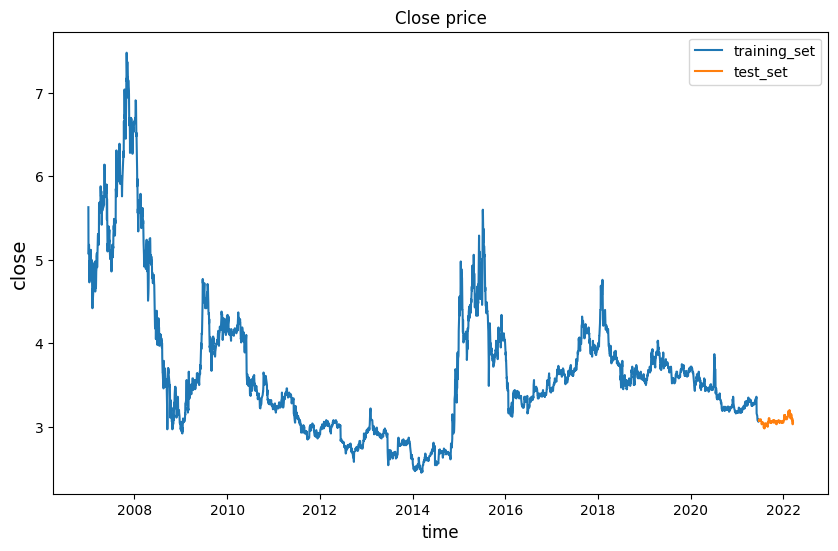

<ipython-input-12-61c2c32ebd4a>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_set['diff_1'] = training_set['close'].diff(1)


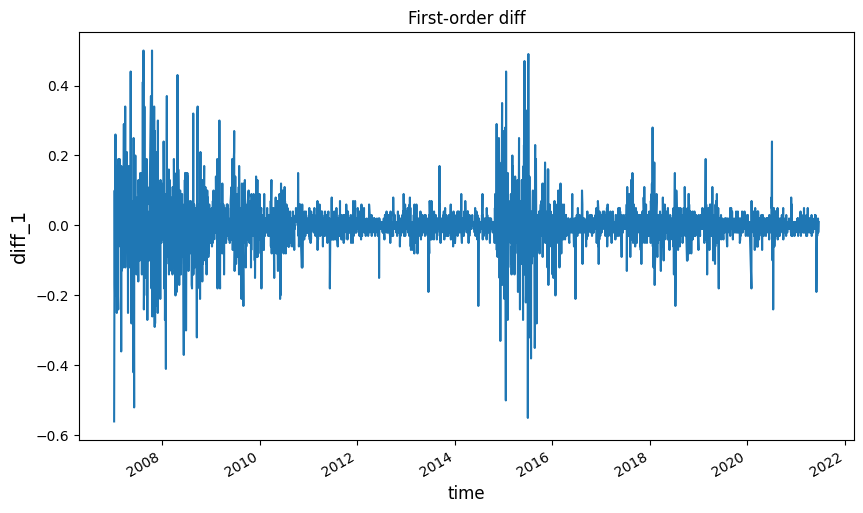

<ipython-input-12-61c2c32ebd4a>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_set['diff_2'] = training_set['diff_1'].diff(1)


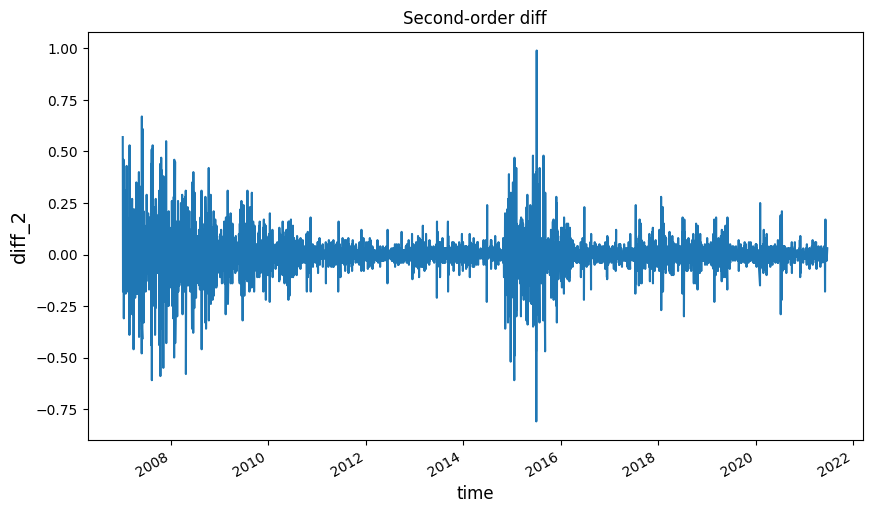

     lb_stat  lb_pvalue    bp_stat  bp_pvalue
1   3.458346   0.062933   3.455383   0.063046
2  23.695323   0.000007  23.669246   0.000007


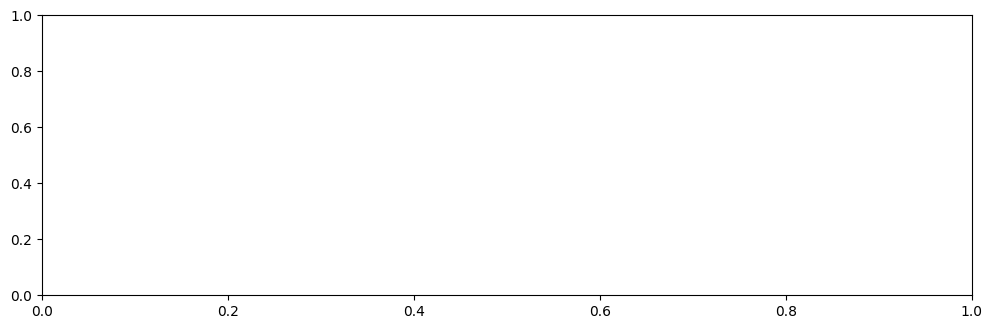

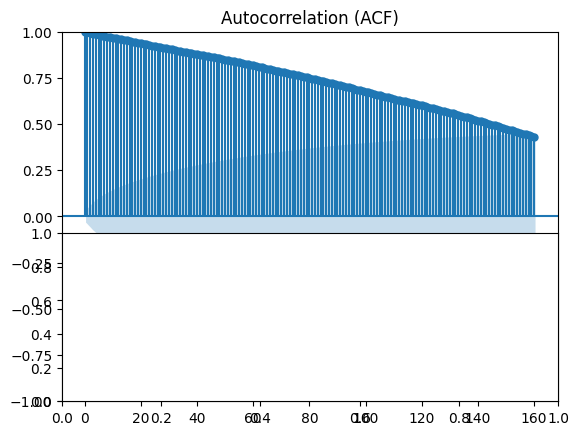

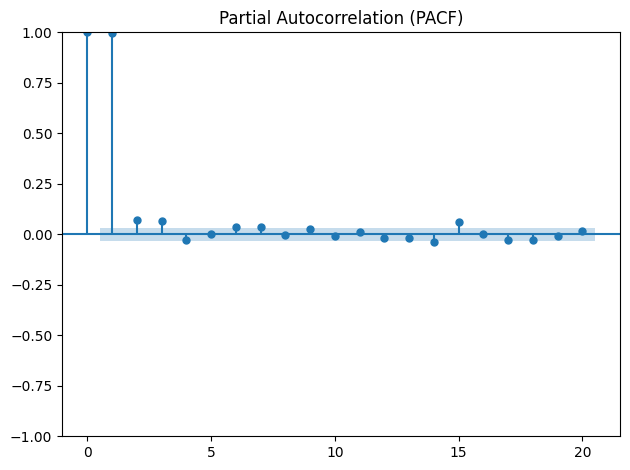

&             close
trade_date       
2007-01-05  -0.56
2007-01-08   0.01
2007-01-09   0.10
2007-01-10  -0.08
2007-01-11  -0.17
...           ...
2021-06-15  -0.01
2021-06-16   0.02
2021-06-17  -0.01
2021-06-18  -0.02
2021-06-21   0.01

[3500 rows x 1 columns]


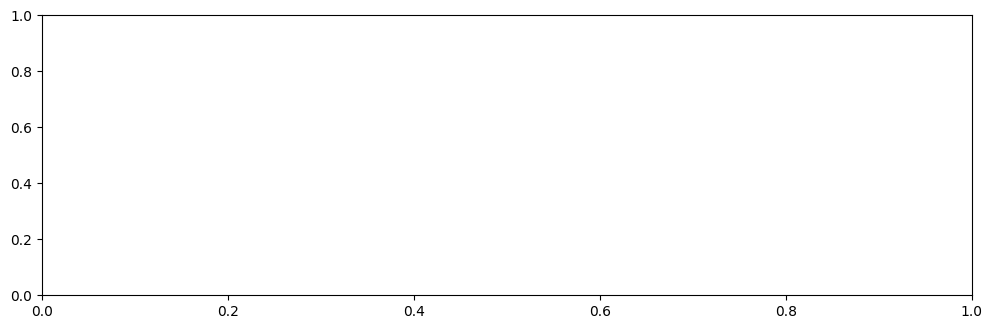

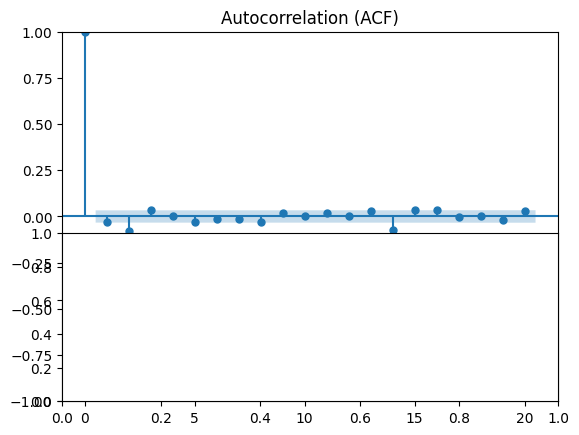

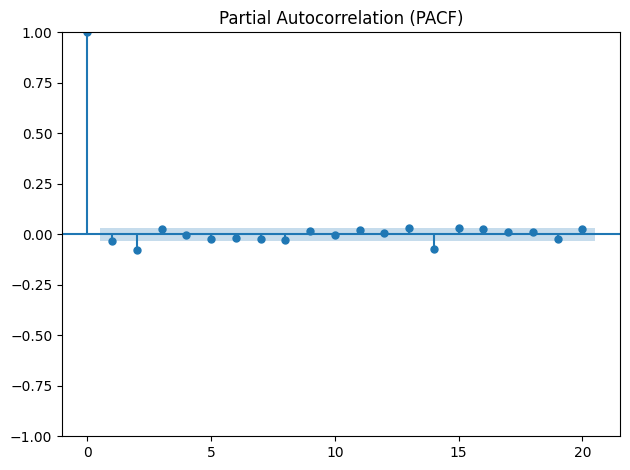

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


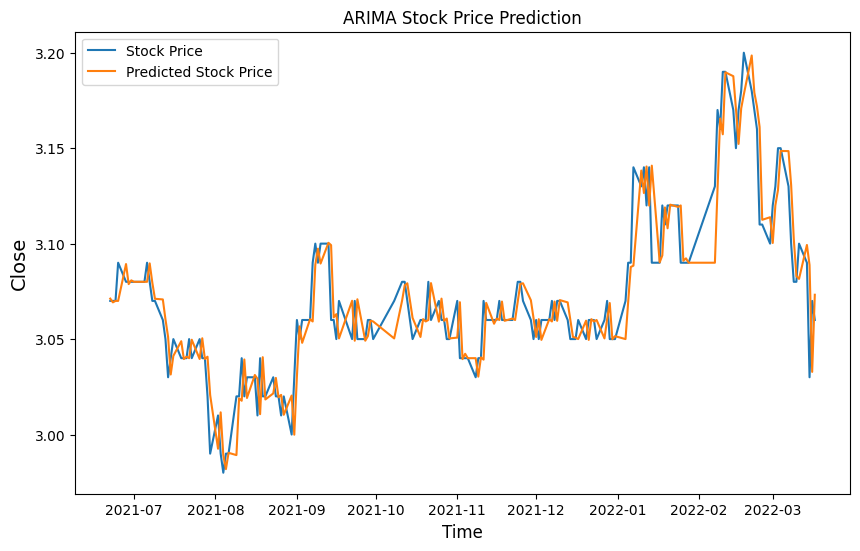

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


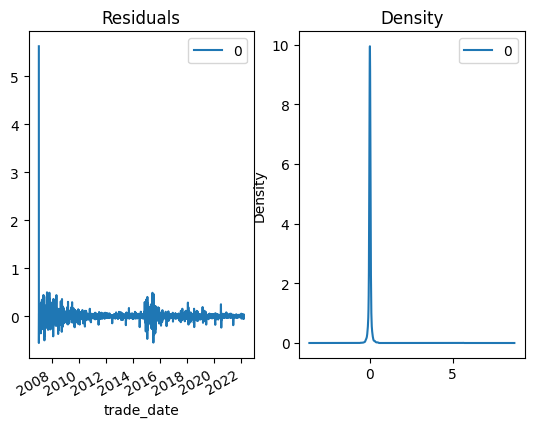

MSE: 0.00027
RMSE: 0.01650
MAE: 0.01197
R2: 0.84439
                                Value
Metric                               
ADF Statistic               -2.355387
p-value                      0.154726
No. of Lags Used            16.000000
No. of Observations Used  3484.000000
Critical Value (1%)         -3.432228
Critical Value (5%)         -2.862370
Critical Value (10%)        -2.567212
                                 Value
Metric                                
ADF Statistic            -1.474975e+01
p-value                   2.495648e-27
No. of Lags Used          1.500000e+01
No. of Observations Used  3.484000e+03
Critical Value (1%)      -3.432228e+00
Critical Value (5%)      -2.862370e+00
Critical Value (10%)     -2.567212e+00
# trade_date
2021-05-20    3.270340
2021-05-21    3.280430
2021-05-24    3.279230
2021-05-25    3.289660
2021-05-26    3.318209
2021-05-27    3.317690
2021-05-28    3.310340
2021-05-31    3.339749
2021-06-01    3.328031
2021-06-02    3.340430
2021-06-03  

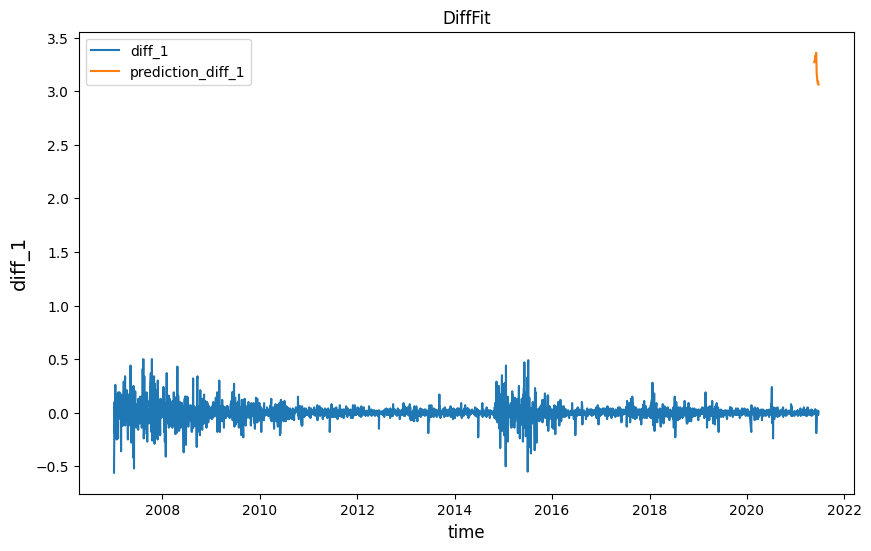

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn import metrics



data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/601988.SH.csv')
test_set2 = data.loc[3501:, :]
data.index = pd.to_datetime(data['trade_date'], format='%Y%m%d')
data = data.drop(['ts_code', 'trade_date'], axis=1)
data = pd.DataFrame(data, dtype=np.float64)

training_set = data.loc['2007-01-04':'2021-06-21', :]
test_set = data.loc['2021-06-22':, :]

plt.figure(figsize=(10, 6))
plt.plot(training_set['close'], label='training_set')
plt.plot(test_set['close'], label='test_set')
plt.title('Close price')
plt.xlabel('time', fontsize=12, verticalalignment='top')
plt.ylabel('close', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()

temp = np.array(training_set['close'])


training_set['diff_1'] = training_set['close'].diff(1)
plt.figure(figsize=(10, 6))
training_set['diff_1'].plot()
plt.title('First-order diff')
plt.xlabel('time', fontsize=12, verticalalignment='top')
plt.ylabel('diff_1', fontsize=14, horizontalalignment='center')
plt.show()

# Second-order diff
training_set['diff_2'] = training_set['diff_1'].diff(1)
plt.figure(figsize=(10, 6))
training_set['diff_2'].plot()
plt.title('Second-order diff')
plt.xlabel('time', fontsize=12, verticalalignment='top')
plt.ylabel('diff_2', fontsize=14, horizontalalignment='center')
plt.show()


temp1 = np.diff(training_set['close'], n=1)

training_data1 = training_set['close'].diff(1)

temp2 = np.diff(training_set['close'], n=1)

print(acorr_ljungbox(temp2, lags=2, boxpierce=True))


plot_acf_pacf(training_set['close'],acf_lags=160)

price = list(temp2)
data2 = {
    'trade_date': training_set['diff_1'].index[1:],
    'close': price
}

df = pd.DataFrame(data2)
df['trade_date'] = pd.to_datetime(df['trade_date'], format='%Y%m%d')

training_data_diff = df.set_index(['trade_date'], drop=True)
print('&', training_data_diff)

plot_acf_pacf(training_data_diff)


model = sm.tsa.ARIMA(endog=training_set['close'], order=(2, 1, 0)).fit()


history = [x for x in training_set['close']]

predictions = list()

for t in range(test_set.shape[0]):
    model1 = sm.tsa.ARIMA(history, order=(2, 1, 0))
    model_fit = model1.fit()
    yhat = model_fit.forecast()
    yhat = np.float32(yhat[0])
    predictions.append(yhat)
    obs = test_set2.iloc[t, 5]

    history.append(obs)


predictions1 = {
    'trade_date': test_set.index[:],
    'close': predictions
}
predictions1 = pd.DataFrame(predictions1)
predictions1 = predictions1.set_index(['trade_date'], drop=True)
predictions1.to_csv('./ARIMA.csv')
plt.figure(figsize=(10, 6))
plt.plot(test_set['close'], label='Stock Price')
plt.plot(predictions1, label='Predicted Stock Price')
plt.title('ARIMA Stock Price Prediction')
plt.xlabel('Time', fontsize=12, verticalalignment='top')
plt.ylabel('Close', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()


model2 = sm.tsa.ARIMA(endog=data['close'], order=(2, 1, 0)).fit()
residuals = pd.DataFrame(model2.resid)
fig, ax = plt.subplots(1, 2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()
residuals.to_csv('./ARIMA_residuals1.csv')
evaluation_metric(test_set['close'],predictions)
perform_adf_test(temp)
perform_adf_test(temp1)


predictions_ARIMA_diff = pd.Series(model.fittedvalues, copy=True)
predictions_ARIMA_diff = predictions_ARIMA_diff[3479:]
print('#', predictions_ARIMA_diff)
plt.figure(figsize=(10, 6))
plt.plot(training_data_diff, label="diff_1")
plt.plot(predictions_ARIMA_diff, label="prediction_diff_1")
plt.xlabel('time', fontsize=12, verticalalignment='top')
plt.ylabel('diff_1', fontsize=14, horizontalalignment='center')
plt.title('DiffFit')
plt.legend()
plt.show()


## Define CNN-LSTM model

In [ ]:
from keras.layers import Input, Dense, LSTM, Conv1D, Dropout, Bidirectional, Multiply, Permute, Lambda, RepeatVector, Flatten
from keras.models import Model, Sequential
from keras import backend as K
import tensorflow as tf
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler  # For data normalization


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dropout, BatchNormalization, Bidirectional, Dense
from sklearn.model_selection import GridSearchCV
import numpy as np
import tensorflow as tf

def lstm_optimized(model_type, X_train, yuan_X_train, units=128, activation='tanh', dropout_rate=0.3):

    model, yuan_model = Sequential(), Sequential()

    # Optimizing for deeper and more complex models with higher units
    if model_type == 1:
        model.add(LSTM(units=units, activation=activation, input_shape=(X_train.shape[1], 1), return_sequences=True))
        model.add(Dropout(dropout_rate))
        model.add(BatchNormalization())
        model.add(LSTM(units=units//2, activation=activation))
        model.add(Dropout(dropout_rate))
        model.add(Dense(units=1))

        yuan_model.add(LSTM(units=units, activation=activation, input_shape=(yuan_X_train.shape[1], 5), return_sequences=True))
        yuan_model.add(Dropout(dropout_rate))
        yuan_model.add(BatchNormalization())
        yuan_model.add(LSTM(units=units//2, activation=activation))
        yuan_model.add(Dropout(dropout_rate))
        yuan_model.add(Dense(units=5))

    elif model_type == 2:
        model.add(LSTM(units=units, activation=activation, return_sequences=True, input_shape=(X_train.shape[1], 1)))
        model.add(Dropout(dropout_rate))
        model.add(BatchNormalization())
        model.add(LSTM(units=units//2, activation=activation))
        model.add(Dropout(dropout_rate))
        model.add(Dense(units=32, activation='relu'))
        model.add(Dense(units=1))

        yuan_model.add(LSTM(units=units, activation=activation, return_sequences=True, input_shape=(yuan_X_train.shape[1], 5)))
        yuan_model.add(Dropout(dropout_rate))
        yuan_model.add(BatchNormalization())
        yuan_model.add(LSTM(units=units//2, activation=activation))
        yuan_model.add(Dropout(dropout_rate))
        yuan_model.add(Dense(units=32, activation='relu'))
        yuan_model.add(Dense(units=5))

    elif model_type == 3:
        model.add(Bidirectional(LSTM(units, activation=activation, return_sequences=True), input_shape=(X_train.shape[1], 1)))
        model.add(Dropout(dropout_rate))
        model.add(BatchNormalization())
        model.add(LSTM(units=units//2, activation=activation))
        model.add(Dropout(dropout_rate))
        model.add(Dense(1))

        yuan_model.add(Bidirectional(LSTM(units, activation=activation, return_sequences=True), input_shape=(yuan_X_train.shape[1], 5)))
        yuan_model.add(Dropout(dropout_rate))
        yuan_model.add(BatchNormalization())
        yuan_model.add(LSTM(units=units//2, activation=activation))
        yuan_model.add(Dropout(dropout_rate))
        yuan_model.add(Dense(5))

    else:
        raise ValueError("Invalid model_type. Expected values: 1, 2, or 3.")

    # Use Adam optimizer with a smaller learning rate (e.g., 0.001)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    yuan_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    return model, yuan_model

## Define XG-Boosting

In [ ]:
import numpy as np
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

# Adjusting function to include standard scaling
def xgb_scheduler(data, y_hat):
    close = data.pop('close')
    data.insert(5, 'close', close)
    train, test = prepare_data(data, n_test=len(y_hat), n_in=6, n_out=1)
    testY, y_hat2 = walk_forward_validation(train, test)
    return testY, y_hat2

# Optimized XGBoost forecast function with scaling
def xgboost_forecast(train, testX, n_estimators=50, max_depth=3, learning_rate=0.05):
    # Prepare data for model training
    train = np.asarray(train)
    trainX, trainy = train[:, :-1], train[:, -1]

    # Scale features
    scaler = StandardScaler()
    trainX = scaler.fit_transform(trainX)
    testX = scaler.transform(np.asarray([testX]))

    # Set up model with additional tuning parameters
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=n_estimators,
                             max_depth=max_depth, learning_rate=learning_rate, n_jobs=-1)
    model.fit(trainX, trainy)

    # Make a one-step prediction
    yhat = model.predict(testX)
    return yhat[0]

def walk_forward_validation(train, test, n_estimators=20, max_depth=3, learning_rate=0.1):
    predictions = []
    train = train.values
    history = [x for x in train]

    for i in range(len(test)):
        testX, testy = test.iloc[i, :-1], test.iloc[i, -1]
        yhat = xgboost_forecast(history, testX, n_estimators=n_estimators,
                                max_depth=max_depth, learning_rate=learning_rate)
        predictions.append(yhat)
        history = np.append(history, [test.iloc[i, :].values], axis=0)  # Append new observation to history
        print(f'{i+1} > expected={testy:.6f}, predicted={yhat:.6f}')

    return test.iloc[:, -1], predictions

# Function to perform grid search for parameter tuning
def tune_xgboost(train):
    train = np.asarray(train)
    trainX, trainy = train[:, :-1], train[:, -1]

    param_grid = {
        'n_estimators': [50, 100, 150],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1]
    }

    model = xgb.XGBRegressor(objective='reg:squarederror', n_jobs=-1)
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
    grid_search.fit(trainX, trainy)

    print(f'Best Parameters: {grid_search.best_params_}')
    return grid_search.best_params_


## Load the original data and the Arima Model trained Residual Data for prediction with XG-Boost.

In [ ]:
def data_prepration(data, n_test, n_in, n_out=1):
    """
    Prepares the dataset for supervised learning, creating lagged input and output sequences.

    Parameters:
    data (DataFrame): The input time series data.
    n_test (int): Number of observations for the test set.
    n_in (int): Number of lagged input steps.
    n_out (int, optional): Number of output steps. Defaults to 1.

    Returns:
    tuple: Training set (DataFrame) and testing set (DataFrame).
    """

    df = pd.DataFrame(data)
    cols, names = list(), list()

    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(df.shape[1])]

    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(df.shape[1])]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(df.shape[1])]

    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names

    # Drop rows with NaN values
    agg.dropna(inplace=True)

    # Split into train and test sets
    train = agg[:-n_test]
    test = agg[-n_test:]  # Ensure n_test samples in the test set

    return train, test

Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}
1 > expected=-0.001188, predicted=-0.010821
2 > expected=0.000766, predicted=-0.003746
3 > expected=0.000000, predicted=0.000474
4 > expected=0.020000, predicted=0.004671
5 > expected=-0.009312, predicted=-0.005932
6 > expected=0.001188, predicted=-0.003499
7 > expected=-0.000766, predicted=-0.005534
8 > expected=0.000000, predicted=0.003943
9 > expected=0.000000, predicted=0.003387
10 > expected=0.000000, predicted=-0.003023
11 > expected=0.010000, predicted=-0.000430
12 > expected=-0.009656, predicted=-0.003439
13 > expected=-0.009578, predicted=0.003118
14 > expected=-0.001110, predicted=-0.004607
15 > expected=-0.010766, predicted=-0.006722
16 > expected=-0.010344, predicted=-0.002715
17 > expected=-0.021110, predicted=0.004650
18 > expected=0.008546, predicted=-0.005842
19 > expected=0.008812, predicted=-0.003233
20 > expected=-0.008890, predicted=-0.003036
21 > expected=0.000422, predicted=-0.002814
22 >

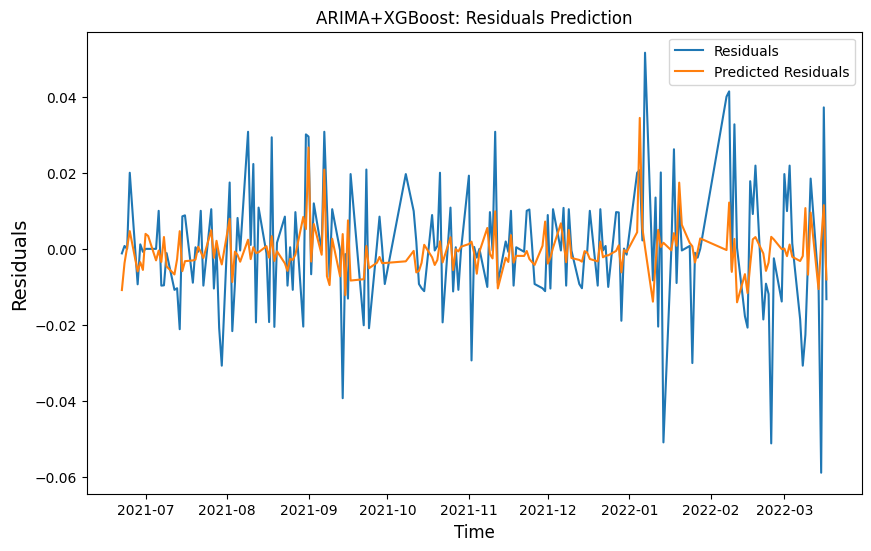

MSE: 0.00024
RMSE: 0.01564
MAE: 0.01137
R2: 0.86018


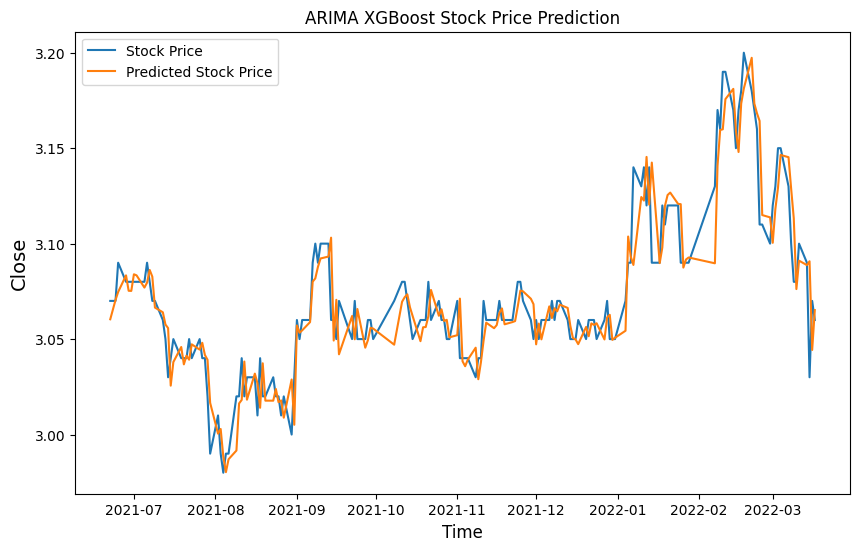

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load stock data
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/601988.SH.csv')
data.index = pd.to_datetime(data['trade_date'], format='%Y%m%d')
data = data[['open', 'high', 'low', 'close', 'vol', 'amount']]

# Separate and reorder 'close' prices
close = data.pop('close')
data.insert(5, 'close', close)

# Load residuals and merge
residuals = pd.read_csv('/content/ARIMA_residuals1.csv')
residuals.index = pd.to_datetime(residuals['trade_date'])
residuals.pop('trade_date')
merge_data = pd.merge(data, residuals, on='trade_date')

# Create time series for plotting
time = pd.Series(data.index[3501:])

# Load ARIMA predictions
Lt = pd.read_csv('/content/ARIMA.csv')
Lt = Lt.drop('trade_date', axis=1).values.flatten().tolist()

# Prepare training and test data
train, test = data_prepration(merge_data, n_test=180, n_in=6, n_out=1)

best_params = tune_xgboost(train)

y, yhat = walk_forward_validation(train, test,
                                  n_estimators=best_params['n_estimators'],
                                  max_depth=best_params['max_depth'],
                                  learning_rate=best_params['learning_rate'])


y = y[:len(time)]
yhat = yhat[:len(time)]

plt.figure(figsize=(10, 6))
plt.plot(time, y, label='Residuals')
plt.plot(time, yhat, label='Predicted Residuals')
plt.title('ARIMA+XGBoost: Residuals Prediction')
plt.xlabel('Time', fontsize=12, verticalalignment='top')
plt.ylabel('Residuals', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()

finalpredicted_stock_price = [i + j for i, j in zip(Lt, yhat)]


evaluation_metric(data['close'][3501:], finalpredicted_stock_price)
plt.figure(figsize=(10, 6))
plt.plot(time, data['close'][3501:], label='Stock Price')
plt.plot(time, finalpredicted_stock_price, label='Predicted Stock Price')
plt.title('ARIMA XGBoost Stock Price Prediction')
plt.xlabel('Time', fontsize=12, verticalalignment='top')
plt.ylabel('Close', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()


##  CNN-LSTM to improve the previous result

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 10, 256)             │         133,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 10, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 216,385 (845.25 KB)

 Trainable params: 215,873 (843.25 KB)

 Non-trainable params: 512 (2.00 KB)

None
Epoch 1/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - loss: 0.2569 - val_loss: 0.0312
Epoch 2/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0133 - val_loss: 0.0281
Epoch 3/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.0096 - val_loss: 0.0272
Epoch 4/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0081 - val_loss: 0.0246
Epoch 5/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.0059 - val_loss: 0.0244
Epoch 6/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - loss: 0.0059 - val_loss: 0.0241
Epoch 7/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - loss: 0.0051 - val_loss: 0.0238
Epoch 8/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0047 - val_loss: 0.0236
Epoch 9/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0047 - val_loss: 0.0235
Epoch 10/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - loss: 0.0045 - val_loss: 0.0239
Epoch 11/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0047 - val_loss: 0.0236
Epoch 12/100
110/110 ━━━

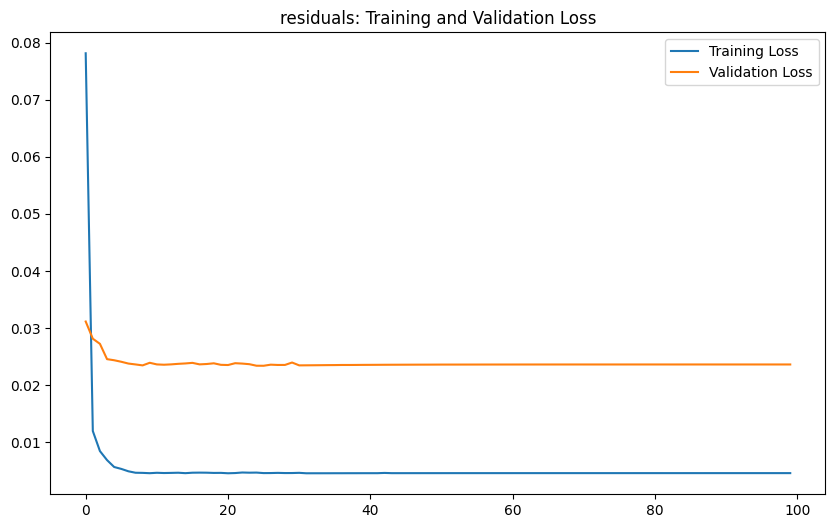

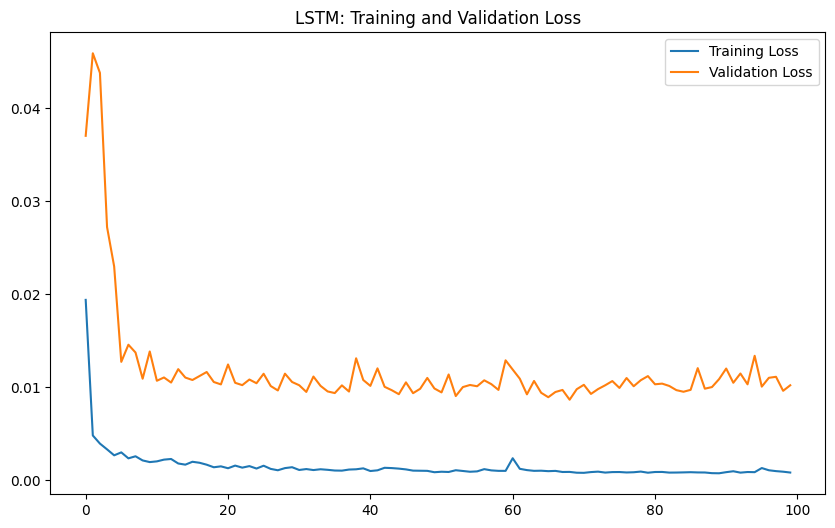

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step


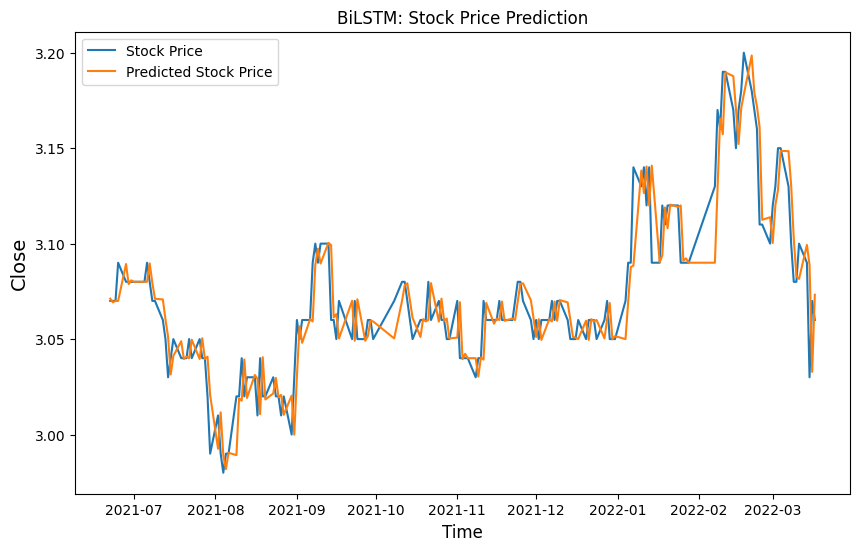

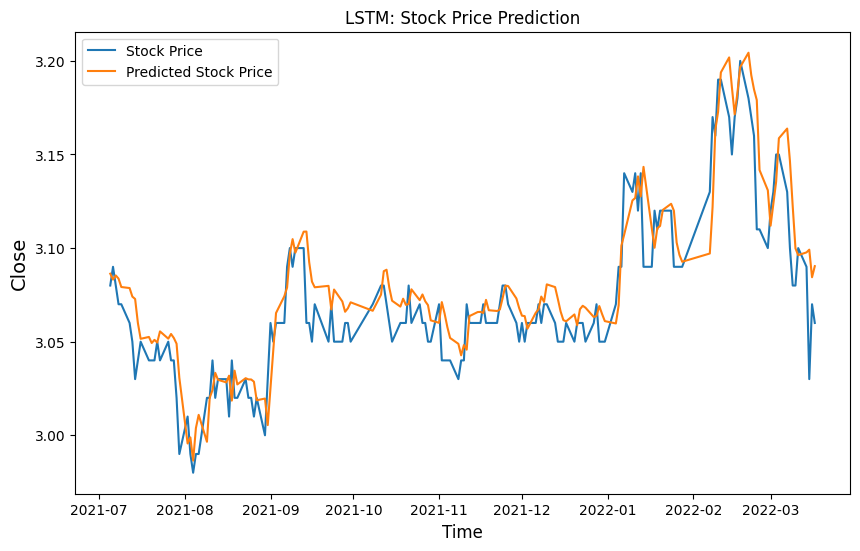

MSE: 0.00027
RMSE: 0.01650
MAE: 0.01197
R2: 0.84235


In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional
from keras.optimizers import Adam
# from tensorflow.keras.optimizers import Adam
from numpy.random import seed


gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    tf.config.set_visible_devices([gpus[0]], "GPU")

seed(1)
tf.random.set_seed(1)

n_timestamp = 10
n_epochs = 50

model_type = 3

yuan_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/601988.SH.csv')
yuan_data.index = pd.to_datetime(yuan_data['trade_date'], format='%Y%m%d')
yuan_data = yuan_data.loc[:, ['open', 'high', 'low', 'close', 'amount']]

data = pd.read_csv('/content/ARIMA_residuals1.csv')
data.index = pd.to_datetime(data['trade_date'])
data = data.drop('trade_date', axis=1)


Lt = pd.read_csv('/content/ARIMA.csv')
idx = 3500
training_set = data.iloc[1:idx, :]
test_set = data.iloc[idx:, :]
yuan_training_set = yuan_data.iloc[1:idx, :]
yuan_test_set = yuan_data.iloc[idx:, :]

sc = MinMaxScaler(feature_range=(0, 1))
yuan_sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)
testing_set_scaled = sc.fit_transform(test_set)
yuan_training_set_scaled = yuan_sc.fit_transform(yuan_training_set)
yuan_testing_set_scaled = yuan_sc.fit_transform(yuan_test_set)

X_train, y_train = data_split(training_set_scaled, n_timestamp)
yuan_X_train, yuan_y_train = data_split(yuan_training_set_scaled, n_timestamp)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
yuan_X_train = yuan_X_train.reshape(yuan_X_train.shape[0], yuan_X_train.shape[1], 5)

X_test, y_test = data_split(testing_set_scaled, n_timestamp)

X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
yuan_X_test, yuan_y_test = data_split(yuan_testing_set_scaled, n_timestamp)
yuna_X_test = yuan_X_test.reshape(yuan_X_test.shape[0], yuan_X_test.shape[1], 5)

model, yuan_model = lstm_optimized(model_type, X_train, yuan_X_train)

print(model.summary())
adam1 = Adam(learning_rate=0.01)
adam2 = Adam(learning_rate=0.01)

model.compile(optimizer=adam1,
              loss='mse')
yuan_model.compile(optimizer=adam2,
                   loss='mse')

history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=100,  # increased epochs for better training
                    validation_data=(X_test, y_test),
                    validation_freq=1)

yuan_history = yuan_model.fit(yuan_X_train, yuan_y_train,
                              batch_size=32,
                              epochs=100,  # increased epochs
                              validation_data=(yuan_X_test, yuan_y_test),
                              validation_freq=1)


plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('residuals: Training and Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(yuan_history.history['loss'], label='Training Loss')
plt.plot(yuan_history.history['val_loss'], label='Validation Loss')
plt.title('LSTM: Training and Validation Loss')
plt.legend()
plt.show()

yuan_predicted_stock_price = yuan_model.predict(yuan_X_test)
yuan_predicted_stock_price = yuan_sc.inverse_transform(yuan_predicted_stock_price)
yuan_predicted_stock_price_list = np.array(yuan_predicted_stock_price[:, 3]).flatten().tolist()
yuan_predicted_stock_price1 = {
    'trade_date': yuan_data.index[idx+10:],
    'close': yuan_predicted_stock_price_list
}
yuan_predicted_stock_price1 = pd.DataFrame(yuan_predicted_stock_price1)
yuan_predicted_stock_price1 = yuan_predicted_stock_price1.set_index(['trade_date'], drop=True)
yuan_real_stock_price = yuan_sc.inverse_transform(yuan_y_test)
yuan_real_stock_price_list = np.array(yuan_real_stock_price[:, 3]).flatten().tolist()
yuan_real_stock_price1 = {
    'trade_date': yuan_data.index[idx+10:],
    'close': yuan_real_stock_price_list
}
yuan_real_stock_price1 = pd.DataFrame(yuan_real_stock_price1)
yuan_real_stock_price1 = yuan_real_stock_price1.set_index(['trade_date'], drop=True)

predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
predicted_stock_price_list = np.array(predicted_stock_price[:, 0]).flatten().tolist()

predicted_stock_price1 = {
    'trade_date': data.index[idx+10:],
    'close': predicted_stock_price_list
}
predicted_stock_price1 = pd.DataFrame(predicted_stock_price1)

predicted_stock_price1 = predicted_stock_price1.set_index(['trade_date'], drop=True)

real_stock_price = sc.inverse_transform(y_test)
finalpredicted_stock_price = pd.concat([Lt, predicted_stock_price1]).groupby('trade_date')['close'].sum().reset_index()
finalpredicted_stock_price.index = pd.to_datetime(finalpredicted_stock_price['trade_date'])
finalpredicted_stock_price = finalpredicted_stock_price.drop(['trade_date'], axis=1)

plt.figure(figsize=(10, 6))
# print('yuan_real', yuan_real_stock_price1)
plt.plot(yuan_data.loc['2021-06-22':, 'close'], label='Stock Price')
plt.plot(finalpredicted_stock_price['close'], label='Predicted Stock Price')
plt.title('BiLSTM: Stock Price Prediction')
plt.xlabel('Time', fontsize=12, verticalalignment='top')
plt.ylabel('Close', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(yuan_real_stock_price1['close'], label='Stock Price')
plt.plot(yuan_predicted_stock_price1['close'], label='Predicted Stock Price')
plt.title('LSTM: Stock Price Prediction')
plt.xlabel('Time', fontsize=12, verticalalignment='top')
plt.ylabel('Close', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()

yhat = yuan_data.loc['2021-06-22':, 'close']
evaluation_metric(finalpredicted_stock_price['close'],yhat)

In [ ]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Attention, Layer
from tensorflow.keras import Input, Model

def improved_lstm(model_type, X_train, yuan_X_train, units=64, activation='tanh', dropout_rate=0.2):

    model, yuan_model = Sequential(), Sequential()

    if model_type == 1:
        model.add(LSTM(units=units, activation=activation, input_shape=(X_train.shape[1], 1),
                       kernel_regularizer=regularizers.l2(0.01)))
        model.add(Dropout(dropout_rate))
        model.add(Dense(units=1))

        yuan_model.add(LSTM(units=units, activation=activation, input_shape=(yuan_X_train.shape[1], 5),
                            kernel_regularizer=regularizers.l2(0.01)))
        yuan_model.add(Dropout(dropout_rate))
        yuan_model.add(Dense(units=5))

    elif model_type == 2:
        model.add(LSTM(units=units, activation=activation, return_sequences=True, input_shape=(X_train.shape[1], 1)))
        model.add(Dropout(dropout_rate))
        model.add(BatchNormalization())

        model.add(LSTM(units=units // 2, activation=activation))
        model.add(Dropout(dropout_rate))
        model.add(Dense(units=32, activation='relu'))
        model.add(Dense(units=1))

        yuan_model.add(LSTM(units=units, activation=activation, return_sequences=True, input_shape=(yuan_X_train.shape[1], 5)))
        yuan_model.add(Dropout(dropout_rate))
        yuan_model.add(BatchNormalization())

        yuan_model.add(LSTM(units=units // 2, activation=activation))
        yuan_model.add(Dropout(dropout_rate))
        yuan_model.add(Dense(units=32, activation='relu'))
        yuan_model.add(Dense(units=5))

    elif model_type == 3:
        # Add Attention Mechanism for better temporal dependency
        # Define input layer
        inputs = Input(shape=(X_train.shape[1], 1))

        # Bidirectional LSTM layer
        x = Bidirectional(LSTM(units, activation=activation, return_sequences=True))(inputs)

        # Attention layer (using query, value, key from Bidirectional LSTM output)
        attention_output = Attention()([x, x, x])  # query, value, key

        x = Dropout(dropout_rate)(attention_output)
        x = BatchNormalization()(x)
        outputs = Dense(1)(x)

        model = Model(inputs=inputs, outputs=outputs)


        # Repeat for yuan_model
        yuan_inputs = Input(shape=(yuan_X_train.shape[1], 5))
        yuan_x = Bidirectional(LSTM(units, activation=activation, return_sequences=True))(yuan_inputs)
        yuan_attention_output = Attention()([yuan_x, yuan_x, yuan_x])

        yuan_x = Dropout(dropout_rate)(yuan_attention_output)
        yuan_x = BatchNormalization()(yuan_x)
        yuan_x = tf.keras.layers.GlobalAveragePooling1D()(yuan_x)
        yuan_outputs = Dense(5)(yuan_x)

        yuan_model = Model(inputs=yuan_inputs, outputs=yuan_outputs)

    else:
        raise ValueError("Invalid model_type. Expected values: 1, 2, or 3.")

    model.compile(optimizer='adam', loss='mse')
    yuan_model.compile(optimizer='adam', loss='mse')

    return model, yuan_model


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 10, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_2           │ (None, 10, 128)        │         33,792 │ input_layer_2[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention (Attention)     │ (None, 10, 128)        │              0 │ bidirectional_2[0][0], │
│                           │                        │                │ bidirectional_2[0][0], │
│                           │                        │                │ bidirectional_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 10, 128)        │              0 │ attention[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 10, 128)        │            512 │ dropout_4[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 10, 1)          │            129 │ batch_normalization_2… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 34,433 (134.50 KB)

 Trainable params: 34,177 (133.50 KB)

 Non-trainable params: 256 (1.00 KB)

None
Epoch 1/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.0590 - val_loss: 0.0244
Epoch 2/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0054 - val_loss: 0.0244
Epoch 3/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0055 - val_loss: 0.0243
Epoch 4/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0055 - val_loss: 0.0241
Epoch 5/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0055 - val_loss: 0.0242
Epoch 6/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0054 - val_loss: 0.0235
Epoch 7/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0053 - val_loss: 0.0237
Epoch 8/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0053 - val_loss: 0.0248
Epoch 9/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0052 - val_loss: 0.0239
Epoch 10/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0052 - val_loss: 0.0241
Epoch 11/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0051 - val_loss: 0.0243
Epoch 12/100
110/110 ━━━━

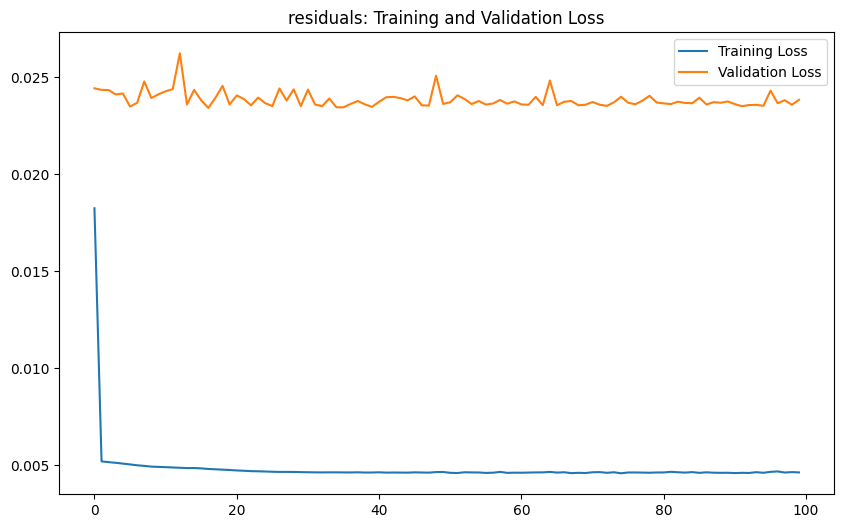

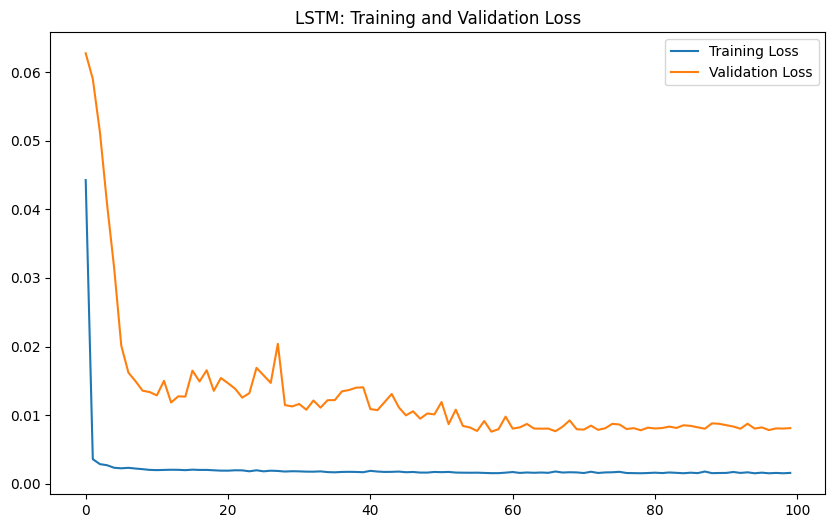

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


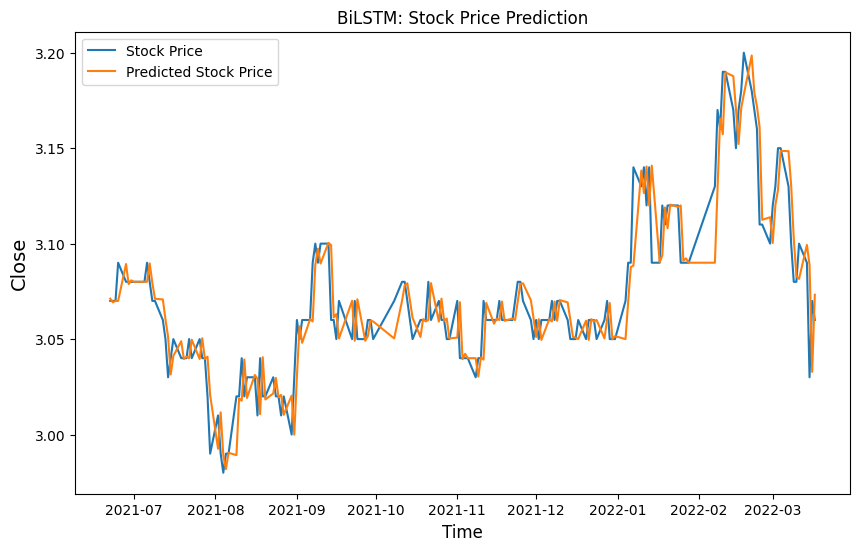

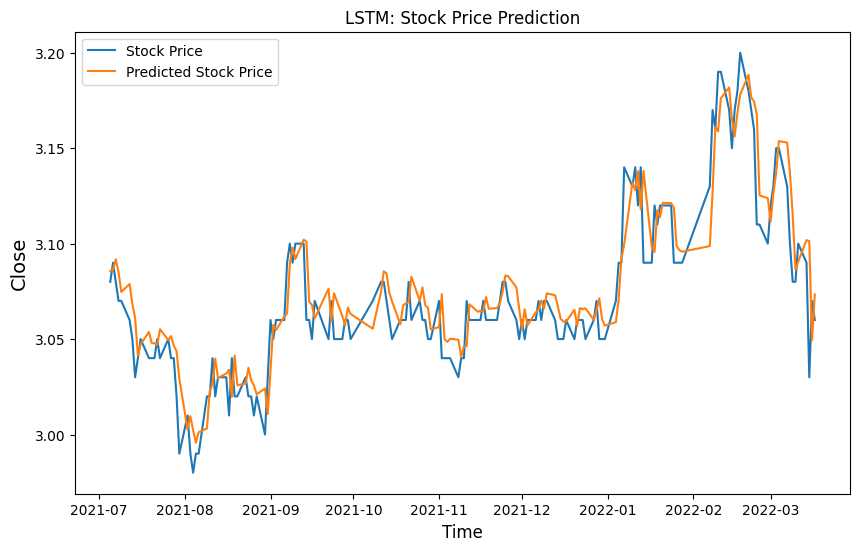

MSE: 0.00027
RMSE: 0.01650
MAE: 0.01197
R2: 0.84235


In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional
from keras.optimizers import Adam
# from tensorflow.keras.optimizers import Adam
from numpy.random import seed


gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    tf.config.set_visible_devices([gpus[0]], "GPU")

seed(1)
tf.random.set_seed(1)

n_timestamp = 10
n_epochs = 50

model_type = 3

yuan_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/601988.SH.csv')
yuan_data.index = pd.to_datetime(yuan_data['trade_date'], format='%Y%m%d')
yuan_data = yuan_data.loc[:, ['open', 'high', 'low', 'close', 'amount']]

data = pd.read_csv('/content/ARIMA_residuals1.csv')
data.index = pd.to_datetime(data['trade_date'])
data = data.drop('trade_date', axis=1)


Lt = pd.read_csv('/content/ARIMA.csv')
idx = 3500
training_set = data.iloc[1:idx, :]
test_set = data.iloc[idx:, :]
yuan_training_set = yuan_data.iloc[1:idx, :]
yuan_test_set = yuan_data.iloc[idx:, :]

sc = MinMaxScaler(feature_range=(0, 1))
yuan_sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)
testing_set_scaled = sc.fit_transform(test_set)
yuan_training_set_scaled = yuan_sc.fit_transform(yuan_training_set)
yuan_testing_set_scaled = yuan_sc.fit_transform(yuan_test_set)

X_train, y_train = data_split(training_set_scaled, n_timestamp)
yuan_X_train, yuan_y_train = data_split(yuan_training_set_scaled, n_timestamp)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
yuan_X_train = yuan_X_train.reshape(yuan_X_train.shape[0], yuan_X_train.shape[1], 5)

X_test, y_test = data_split(testing_set_scaled, n_timestamp)

X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
yuan_X_test, yuan_y_test = data_split(yuan_testing_set_scaled, n_timestamp)
yuna_X_test = yuan_X_test.reshape(yuan_X_test.shape[0], yuan_X_test.shape[1], 5)

model, yuan_model = improved_lstm(model_type, X_train, yuan_X_train)

print(model.summary())
adam1 = Adam(learning_rate=0.01)
adam2 = Adam(learning_rate=0.01)

model.compile(optimizer=adam1,
              loss='mse')
yuan_model.compile(optimizer=adam2,
                   loss='mse')

history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=100,  # increased epochs for better training
                    validation_data=(X_test, y_test),
                    validation_freq=1)

yuan_history = yuan_model.fit(yuan_X_train, yuan_y_train,
                              batch_size=32,
                              epochs=100,  # increased epochs
                              validation_data=(yuan_X_test, yuan_y_test),
                              validation_freq=1)


plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('residuals: Training and Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(yuan_history.history['loss'], label='Training Loss')
plt.plot(yuan_history.history['val_loss'], label='Validation Loss')
plt.title('LSTM: Training and Validation Loss')
plt.legend()
plt.show()

yuan_predicted_stock_price = yuan_model.predict(yuan_X_test)
yuan_predicted_stock_price = yuan_sc.inverse_transform(yuan_predicted_stock_price)
yuan_predicted_stock_price_list = np.array(yuan_predicted_stock_price[:, 3]).flatten().tolist()
yuan_predicted_stock_price1 = {
    'trade_date': yuan_data.index[idx+10:],
    'close': yuan_predicted_stock_price_list
}
yuan_predicted_stock_price1 = pd.DataFrame(yuan_predicted_stock_price1)
yuan_predicted_stock_price1 = yuan_predicted_stock_price1.set_index(['trade_date'], drop=True)
yuan_real_stock_price = yuan_sc.inverse_transform(yuan_y_test)
yuan_real_stock_price_list = np.array(yuan_real_stock_price[:, 3]).flatten().tolist()
yuan_real_stock_price1 = {
    'trade_date': yuan_data.index[idx+10:],
    'close': yuan_real_stock_price_list
}
yuan_real_stock_price1 = pd.DataFrame(yuan_real_stock_price1)
yuan_real_stock_price1 = yuan_real_stock_price1.set_index(['trade_date'], drop=True)

predicted_stock_price = model.predict(X_test)
predicted_stock_price = predicted_stock_price[:, -1, 0].reshape(-1, 1)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
predicted_stock_price_list = np.array(predicted_stock_price[:, 0]).flatten().tolist()

predicted_stock_price1 = {
    'trade_date': data.index[idx+10:],
    'close': predicted_stock_price_list
}
predicted_stock_price1 = pd.DataFrame(predicted_stock_price1)

predicted_stock_price1 = predicted_stock_price1.set_index(['trade_date'], drop=True)

real_stock_price = sc.inverse_transform(y_test)
finalpredicted_stock_price = pd.concat([Lt, predicted_stock_price1]).groupby('trade_date')['close'].sum().reset_index()
finalpredicted_stock_price.index = pd.to_datetime(finalpredicted_stock_price['trade_date'])
finalpredicted_stock_price = finalpredicted_stock_price.drop(['trade_date'], axis=1)

plt.figure(figsize=(10, 6))
# print('yuan_real', yuan_real_stock_price1)
plt.plot(yuan_data.loc['2021-06-22':, 'close'], label='Stock Price')
plt.plot(finalpredicted_stock_price['close'], label='Predicted Stock Price')
plt.title('BiLSTM: Stock Price Prediction')
plt.xlabel('Time', fontsize=12, verticalalignment='top')
plt.ylabel('Close', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(yuan_real_stock_price1['close'], label='Stock Price')
plt.plot(yuan_predicted_stock_price1['close'], label='Predicted Stock Price')
plt.title('LSTM: Stock Price Prediction')
plt.xlabel('Time', fontsize=12, verticalalignment='top')
plt.ylabel('Close', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()

yhat = yuan_data.loc['2021-06-22':, 'close']
evaluation_metric(finalpredicted_stock_price['close'],yhat)